In [1]:
import numpy as np
import jax.numpy as jnp
import re
import cupy as cp
import pickle
import time
import numpy as np
import jax.numpy as jnp
import pandas as pd
import numpy as np
import jax
import spacy
from tqdm import tqdm
from pathlib import Path
import json

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))


def log_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)  # Execute the wrapped function
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time
        # print(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result

    return wrapper


class Helper: 
    
    def get_positional_encoding(self,seq_len, d_model):
        """
        Returns a non-learnable (sinusoidal) positional encoding.


        seq_len: Length of the input sequence.
        d_model: Dimension of the embeddings.
        """
        pos = cp.arange(seq_len)[:, cp.newaxis]  # Shape: [seq_len, 1]
        i = cp.arange(d_model)[cp.newaxis, :]  # Shape: [1, d_model]

        angle_rates = 1 / cp.power(10000, (2 * (i // 2)) / cp.float32(d_model))

        # Apply sine to even indices, cosine to odd indices
        pos_encoding = cp.zeros((seq_len, d_model))
        pos_encoding[:, 0::2] = cp.sin(pos * angle_rates[:, 0::2])  # sine on even indices
        pos_encoding[:, 1::2] = cp.cos(pos * angle_rates[:, 1::2])  # cosine on odd indices

        return pos_encoding

    @staticmethod
    def softmax(x):
        # Subtract the max value for numerical stability
        max_logits = cp.max(x, axis=-1, keepdims=True)
        exp_logits = cp.exp(x - max_logits)
        return exp_logits / cp.sum(exp_logits, axis=-1, keepdims=True)

 
    # @log_time
    def pad_sequence(self,seq, max_len, pad_value=0):
        """Pad a sequence with a given value up to max_len."""
        current_len = seq.shape[0]
        pad_width = max_len - current_len
        if pad_width > 0:
            # Pad sequence with zeros (or any pad_value you provide)
            seq = cp.pad(seq, ((0, pad_width), (0, 0)), mode='constant', constant_values=pad_value)
        return seq


    @log_time
    def create_timestaped_input(self,input_d, words_per_phrase):
        input_translation = []
        for j in range(input_d.shape[0]):
            # Create padded sequences
            padded_sequences = [self.pad_sequence(input_d[j][0:i], words_per_phrase) for i in range(1, input_d.shape[1] + 1)]
            input_translation.append(padded_sequences)
        return cp.array(input_translation)


    



 
    def redimension(self,X):
        return cp.concatenate(cp.swapaxes(X, 0, 1), axis=-1)
    
    @log_time
    def create_vocabulary(self,complete_text, name, nlp):
        # Use re.findall to split considering punctuation
        text = re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', complete_text)

        words_list = list(set(text))

        vocabulary = dict()

        for i, j in enumerate(words_list):
            # vocabulary[j]=(jax.random.uniform(jax.random.key(cp.random.randint(10000)),embedding_size),i)
            vocabulary[j] = (cp.array(nlp(j).vector), i)
            # print(j,len(cp.array(nlp(j).vector)))

        # print(vocabulary)
        # print("Vocabulary size: ", len(vocabulary))
        with open(f"data/{name}.pkl", 'wb') as handle:
            pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return vocabulary


    @log_time
    def pad_sequences(self,sentences, lenght, pad_token='[PAD]', target_type=None):
        """
        Pads the input sentences to have the same length by adding [PAD] tokens at the end.
        """
        regex_str=r'\[.*?\]|\w+|[^\w\s]|\n'

        if target_type == "encoder":
            # Split each sentence into words
            tokenized_sentences = [["[START]"] + re.findall(regex_str, sentence) + ["[END]"] for sentence in sentences]
        elif target_type == "decoder":
            tokenized_sentences = [["[START]"] + re.findall(regex_str, sentence) for sentence in sentences]
        elif target_type == "target":
            tokenized_sentences = [re.findall(regex_str, sentence) + ["[END]"] for sentence in sentences]
        # print(tokenized_sentences)
        if lenght == 0:
            # Find the maximum sentence length
            max_len = max(len(sentence) for sentence in tokenized_sentences)
        else:
            max_len = lenght

        # Pad each sentence with the [PAD] token to make them of equal length
        padded_sentences = [" ".join(sentence + [pad_token] * (max_len - len(sentence))) for sentence in
                            tokenized_sentences]

        return padded_sentences

    def print_matrix(self,X):
        for i in X:
            print(i)

    @log_time
    def generate_input_encoder(self,x_batch, vocabulary_encoder, max_words_per_phrase):


        regex_str=r'\[.*?\]|\w+|[^\w\s]|\n'
        x_train = self.pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")# here are string
        
        #print_matrix(x_train) 
    
        xi = []
        # print(x_batch)
        phrase_vectors_x = [re.findall(regex_str, x) for x in x_train]
        
        phrase_vectors_x = [i[0:max_words_per_phrase] for i in phrase_vectors_x]
        #print(phrase_vectors_x) 
       
        # print("input_encoder:")
        # self.print_matrix(phrase_vectors_x)
        xi = cp.array([[vocabulary_encoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_x])

        return xi
    
    @log_time
    def create_input_encoder(self,X, vocabulary_encoder, max_words_per_phrase, embedding_size):

        pos_encoding = self.get_positional_encoding(max_words_per_phrase, embedding_size)
        #print(pos_encoding)
        inputs_e = self.generate_input_encoder(X, vocabulary_encoder, max_words_per_phrase)
        
        #print(inputs_e)

        inputs_e =inputs_e + pos_encoding
        return inputs_e
    
    def generate_target(self,x_batch, vocabulary_encoder, max_words_per_phrase):

        regex_str=r'\[.*?\]|\w+|[^\w\s]|\n'

        y_target = self.pad_sequences(x_batch, max_words_per_phrase, target_type="target")# here are one string with the padd
        
        
        target_vector = [re.findall(regex_str, x) for x in y_target]

        #print(target_vector)
        #print_matrix(phrase_vectors_x) 
        #target_vector = [i[0:max_words_per_phrase] for i in target_vector]
        target_vector = [i[0:max_words_per_phrase] for i in target_vector]
        target_vector = cp.array([[self.get_one_hot(i,vocabulary_encoder) for i in phrase] for phrase in target_vector])
    
        return target_vector
    
    def generate_target_sparse_categorical(self,y_batch, vocabulary_encoder, max_words_per_phrase):

        regex_str=r'\[.*?\]|\w+|[^\w\s]|\n'

        y_target = self.pad_sequences(y_batch, max_words_per_phrase, target_type="target")# here are one string with the padd
        
        
        target_vector = [re.findall(regex_str, x) for x in y_target]

        #print(target_vector)
        #print_matrix(phrase_vectors_x) 
        #target_vector = [i[0:max_words_per_phrase] for i in target_vector]
        target_vector = [i[0:max_words_per_phrase] for i in target_vector]
        target_vector = cp.array([[vocabulary_encoder[i][1] for i in phrase] for phrase in target_vector])
    
        return target_vector
    
    @log_time
    def create_target(self,X, vocabulary_encoder, max_words_per_phrase): 
        inputs_e = self.generate_target(X, vocabulary_encoder, max_words_per_phrase) 
        return inputs_e

    @log_time
    def create_decoder_input(self,y_train, embedding_size, max_words_per_phrase, vocabulary_decoder):

        decoder_input = self.pad_sequences(y_train, lenght=max_words_per_phrase, target_type="decoder")
        #print_matrix(decoder_input)
        decoder_input = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', i) for i in decoder_input]
        
        if max_words_per_phrase == None:
            max_words_per_phrase = len(decoder_input[0])

        phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
        # for sentence in phrase_vectors_y:
        #     print(sentence)
        #print_matrix(phrase_vectors_y)
        
       

        # print("decoder_input:")
        # self.print_matrix(decoder_input)
        yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
        
        pos_encoding = self.get_positional_encoding(max_words_per_phrase, embedding_size)
        # print(pos_encoding.shape,yi.shape)
        yi = yi + pos_encoding
        #print_matrix(yi)
        # decoder_inputs = cp.array(cp.swapaxes(self.create_timestaped_input(yi, max_words_per_phrase), 0, 1))
        
        # # decoder_inputs[zero_rows] = vocabulary_decoder["[PAD]"][0]
        # for i in range(decoder_inputs.shape[0]):
        #     for j in range(decoder_inputs[i].shape[0]):
        #         zero_rows = cp.all(decoder_inputs[i][j] == 0, axis=1)

        #         decoder_inputs[i][j][zero_rows] = vocabulary_decoder["[PAD]"][0]

        # decoder_inputs = cp.array(decoder_inputs)
        #print(decoder_inputs[2])
        #print(decoder_inputs)
        return yi
    # @log_time
    def update_wembedding_encoder(self,learning_rate, x_batch, dLoss_dWemb_encoder, vocabulary, max_words_per_phrase):
        x_train = self.pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")

        phrase_vectors_x = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in x_train]
        phrase_vectors_x = [i[:max_words_per_phrase] for i in phrase_vectors_x]

        for phrase in range(dLoss_dWemb_encoder.shape[0]):
            for position, word in enumerate(phrase_vectors_x[phrase]):
                # Retrieve current embedding
                current_embedding, index = vocabulary[word]

                # Calculate the updated embedding using the gradient
                updated_embedding = current_embedding - learning_rate * dLoss_dWemb_encoder[phrase][position]

                # Update the vocabulary with the new embedding
                vocabulary[word] = (updated_embedding, index)

        return vocabulary



    # @log_time
    def update_wembedding_decoder(self, learning_rate,y_batch, dLoss_dWemb_decoder, vocabulary,max_words_per_phrase):
        decoder_input = self.pad_sequences(y_batch, lenght=max_words_per_phrase, target_type="decoder")
        decoder_input = [i.split() for i in decoder_input]

        if max_words_per_phrase is None:
            max_words_per_phrase = len(decoder_input[0])

        phrase_vectors_y = [i[:max_words_per_phrase] for i in decoder_input]

        for phrase in range(dLoss_dWemb_decoder.shape[0]):
            for position, word in enumerate(phrase_vectors_y[phrase]):
                # Retrieve current embedding for the word
                current_embedding, index = vocabulary[word]

                # Apply the gradient update
                updated_embedding = current_embedding - learning_rate * dLoss_dWemb_decoder[phrase][position]

                # Update the vocabulary with the new embedding
                vocabulary[word] = (updated_embedding, index)

        return vocabulary

  
    # @log_time
    def get_one_hot(self,word, vocabulary_decoder):
        # print(word)
        vocab_size = len(vocabulary_decoder)
        one_hot_vector = cp.zeros(vocab_size)
        one_hot_vector[vocabulary_decoder[word][1]] = 1
        # print(vocabulary_decoder[word][1])
        # print(np.where(one_hot_vector== 1))
        # print(cp.sum(one_hot_vector))
        return one_hot_vector
 
    
    def log_sparse_entropy(self,ans,target,y_batch,step):
        #print("target",target)
        #print("ans",ans)
        counter_found=0
        total_lenght=len(ans)
        print(f"----DECODER--step {step}---")
        self.print_matrix(y_batch)
        print("target",target)
        indexes=[]
        yy=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in y_batch] 
        for idx, values in enumerate(ans):
            max_index = cp.argmax(values)
            indexes.append(max_index)
             
            if max_index==target[idx]:
                counter_found+=1
            print(f"{idx + 1} base: {' '.join(yy[idx][0:step+1])} -> {max_index}")
        print("indexes",indexes)
        print("accuracy batch:",round(counter_found/total_lenght,2))
        
    def accruacy_sparse_entropy(self,ans,target):
        counter_found=0
        total_lenght=len(ans) 
        for idx, values in enumerate(ans):
            max_index = cp.argmax(values) 
            if max_index==target[idx]:
                counter_found+=1
             
        accuracy_batch_on_step=round(counter_found/total_lenght,2)
        return accuracy_batch_on_step
    

    def print_target_vs_prediction_sparce_loss(self,ans,target): 
        indexes=[] 
        for idx, values in enumerate(ans):
            max_index = np.argmax(values).item()
            indexes.append(max_index) 
        print("target",target)
        print("indexes",indexes)
        
  
def clip_gradient(gradient,threshold):
    return cp.clip(gradient, -threshold, threshold)


    
    
    
    

class layer_dropout: 

    def __init__(self,dropout_rate=0.1):
        self.dropout_rate=dropout_rate 
        self.mask = None

    def forward(self,X):   
        self.mask = (cp.random.rand(*X.shape) > self.dropout_rate)#.astype(cp.float64)
        result = X * self.mask 
        #print(self.mask )
        return result
    #
    def grad(self, X):
        # Only pass gradients through neurons that were not dropped out
        grad_input = X * self.mask
        grad_input = clip_gradient(grad_input, 1)
        return grad_input

class layer_normalization:
    def __init__(self, threshold, epsilon=1e-6):
        self.epsilon = epsilon
        self.mu = 0
        self.var = 0
        self.N = 0
        self.beta = 0
        self.alpha = 0
        self.clipping_threshold = threshold

    def grad_sigma(self):
        result = (2/self.N) * (self.x - self.mu) * (1 - self.grad_mu())
        return result

    def grad_mu(self):
        result = 1/self.N
        return result

    def forward(self, x):
        self.x = x
        self.N = x.shape[-1]
        self.alpha = cp.ones(self.N)
        self.beta = cp.zeros(self.N)
        self.mu = cp.mean(x, axis=-1, keepdims=True)
        self.var=cp.var(x, axis=-1, keepdims=True)

        x_norm = self.alpha * (x - self.mu) /cp.sqrt(self.var+self.epsilon) + self.beta
        return x_norm

    def grad_A(self):
        a = self.alpha * cp.sqrt(self.var+self.epsilon)
        b = self.x * self.alpha * 0.5 * ((self.var+self.epsilon)**(-0.5)) * self.grad_sigma()
        c = (self.var+self.epsilon)
        result = (a - b) / c
        #result = clip_gradient(result, self.clipping_threshold)
        return result

    def grad_B(self):
        a = self.alpha * self.grad_mu() * cp.sqrt(self.var+self.epsilon)
        b = self.mu * self.alpha * 0.5 * ((self.var+self.epsilon)**(-0.5)) * self.grad_sigma()
        c = (self.var+self.epsilon)
        result = (a - b) / c
        #result = clip_gradient(result, self.clipping_threshold)
        return result

    def dL_dalpha(self):
        result = self.dLoss_dy * (self.x - self.mu) / cp.sqrt(self.var+self.epsilon)
        #result = clip_gradient(result, self.clipping_threshold)
        return result

    def dL_dbeta(self):
        result = self.dLoss_dy
        #result = clip_gradient(result, self.clipping_threshold)
        return result

    def backpropagation(self, dLoss_dy):
        self.dLoss_dy = dLoss_dy
        result = self.dLoss_dy * (self.grad_A() + self.grad_B())
        #result = clip_gradient(result, self.clipping_threshold)
        return result

    def params_update(self, learning_rate):
        self.beta = self.beta - self.dL_dbeta() * learning_rate
        self.alpha = self.alpha - self.dL_dalpha() * learning_rate



class output_stack:
    def __init__(self,embedding_size,vocabulary_size,threshold):
        self.final_projection_layer=linear_layer(embedding_size,vocabulary_size,threshold=threshold,out=True)
        self.clipping_threshold=threshold

    def softmax(self,x):
        # Subtract the max value for numerical stability
        max_logits = cp.max(x, axis=-1, keepdims=True)
        exp_logits = cp.exp(x - max_logits)
        return exp_logits / cp.sum(exp_logits, axis=-1, keepdims=True)
    
    def forward(self,x):
        SoftmaxOutput=self.softmax(self.final_projection_layer.forward(x)) 
        return SoftmaxOutput

    
    def cross_entropy_loss(self,SigmaZout, target):
        epsilon = 1e-12  # Small constant to avoid log(0)
        SigmaZout = cp.clip(SigmaZout, epsilon, 1 - epsilon)  # Clipping predictions
        return -cp.sum(target * cp.log(SigmaZout), axis=1).mean() 
    
    def grad_cross_entropy(self,softmax_output,target):
        dL_dZ = dL_dZ=softmax_output-target
        dL_dDout=self.final_projection_layer.grad(dL_dZ)  
        #dL_dDout=clip_gradient(dL_dDout,self.clipping_threshold)
        return dL_dDout
    
    def sparse_categorical_crossentropy(self, probabilities, labels): 
        #print("probabilities.shape", probabilities.shape)
        #print("labels.shape", labels.shape)
        
        # Unpack batch and sequence dimensions
        batch_size, seq_length = labels.shape
        
        # Gather correct class probabilities for each position in the batch and sequence
        correct_class_probs = probabilities[np.arange(batch_size)[:, None], np.arange(seq_length), labels] 
        
        # Calculate the log loss and average it
        loss = -np.log(correct_class_probs + 1e-8)
        return np.mean(loss)
    
    def grad(self,dl_dy):
        return self.final_projection_layer.grad(dl_dy)


    def grad_sparse_cross_entropy(self, softmax_output, target):
        dL_dZ = softmax_output.copy()  # Create a copy of the softmax output
        
        # Adjust indexing to handle both batch and sequence dimensions
        batch_size, seq_length = target.shape
        dL_dZ[np.arange(batch_size)[:, None], np.arange(seq_length), target] -= 1
        
        # Compute gradient through final projection layer
        dL_dDout = self.final_projection_layer.grad(dL_dZ)  
        # dL_dDout = clip_gradient(dL_dDout, self.clipping_threshold)
        return dL_dDout
 
    def update_weights(self,learning_rate):
        self.final_projection_layer.update_weights(learning_rate)



class linear_layer: 
    def __init__(self,input_size,output_size,out=False,only_weights=False,threshold=1):
        if out==True:
            self.W=cp.random.rand(input_size, output_size)/cp.sqrt(input_size)
        else:
            self.W=cp.random.rand(input_size, output_size) 
        if only_weights==True:
            pass
        else: 
            self.b=cp.random.rand(output_size)
        self.clipping_threshold=threshold
      
    def forward(self,x): 
        self.x=x
        Xout = cp.matmul(x, self.W) + self.b 
        return Xout
    
    def forward_weights_only(self,x): 
        self.x=x
        Xout = cp.matmul(x, self.W) 
        return Xout
     
    def grad(self,dL_dy):
        self.dL_dy = dL_dy
        # print("self.dL_dy",self.dL_dy)
        return self.dL_dy@self.W.T
    
    def dLoss_dW(self):
        return cp.sum(cp.transpose(self.dL_dy,(0,2,1))@self.x,axis=0).T
    
    def dLoss_db(self):
        return self.dL_dy 

    def update_weights(self,learning_rate):
        self.W=self.W-learning_rate*self.dLoss_dW()
        self.b=self.b-learning_rate*self.dLoss_db()

    def update_weights_only(self,learning_rate):
        self.W=self.W-learning_rate*self.dLoss_dW()
        
         
class fully_connected_block:
    def __init__(self,embedding_size,hidden_size,clipping_threshold):
        self.embedding_size=embedding_size
        self.hidden_size=hidden_size
        self.linear_layer_1=linear_layer(self.embedding_size,self.hidden_size,threshold=clipping_threshold)
        self.linear_layer_2=linear_layer(self.hidden_size,self.embedding_size,threshold=clipping_threshold)
        self.dropout=layer_dropout()
        self.ReLu=ReLu_layer()

    def forward(self,x):
        x_1=self.linear_layer_1.forward(x)
        x_1_r=self.ReLu.forward_leaky(x_1)
        x_1_rd=self.dropout.forward(x_1_r)
        x_2=self.linear_layer_2.forward(x_1_rd)
        return x_2
    
    def grad(self,dL_dy):
        dL_dx_1_rd=self.linear_layer_2.grad(dL_dy)
        dL_dx_1_r=self.dropout.grad(dL_dx_1_rd)
        dL_dx_1=self.ReLu.backward_leaky(dL_dx_1_r)
        dL_dx=self.linear_layer_1.grad(dL_dx_1)
        return dL_dx
    
    def update_weights(self,learning_rate):
        self.linear_layer_1.update_weights(learning_rate)
        self.linear_layer_2.update_weights(learning_rate)
        
 
class ReLu_layer:
    def __init__(self,alpha=0.0001):
        self.alpha=alpha 
    def forward_leaky(self,X):
        self.X=X
        return cp.where(X > 0, X, self.alpha * X)

    def forward(self,X): 
        self.X=X
        return cp.maximum(0,self.X)
    
    def backward(self, dLoss): 
        # Gradient of ReLU is 1 for x > 0, else 0
        dx = dLoss * (self.X > 0)  # Only propagate gradients for inputs > 0
        return dx
    
    def backward_leaky(self, dLoss): 
        dx = dLoss * cp.where(self.X > 0, 1, self.alpha)  # Gradient: 1 for x > 0, else alpha
        return dx

class residual_layer:
    def __init__(self,threshold):
        self.dropuot=layer_dropout()
        self.normalization=layer_normalization(threshold=threshold)
        self.clipping_threshold=threshold


    def forward(self,x,sublayer_output): 
        residual=self.dropuot.forward(sublayer_output)+x
        result=self.normalization.forward(residual)
        return result
    
    def grad(self,dL_dy): 
        #dL_dy=clip_gradient(dL_dy,1)
       
        dl_dNorm=self.normalization.backpropagation(dL_dy)
        #dl_dNorm=clip_gradient(dl_dNorm,1)

        sublayer_grad=self.dropuot.grad(dl_dNorm)
        residual_grad=dl_dNorm
        return sublayer_grad,residual_grad
    
    def update_weights(self,learning_rate):
        self.normalization.params_update(learning_rate)


      
class multihead_attention: 
    def __init__(self,embedding_size,num_heads,batch_size,threshold):
        self.num_heads=num_heads
        self.dk=embedding_size//num_heads
        self.batch_size=batch_size
        self.embedding_size=embedding_size
        self.q=linear_layer(self.embedding_size,self.embedding_size,only_weights=True,threshold=threshold)
        self.k=linear_layer(self.embedding_size,self.embedding_size,only_weights=True,threshold=threshold)
        self.v=linear_layer(self.embedding_size,self.embedding_size,only_weights=True,threshold=threshold)
        self.projection_layer=linear_layer(self.embedding_size,self.embedding_size,only_weights=True,threshold=threshold) 
        self.helper=Helper()
        self.clipping_threshold=threshold
        
    def reshape_heads(self,Q,K,V):
        self.Q = cp.swapaxes(cp.array(np.array_split(Q, self.num_heads, axis=2)), 0, 1)
        # print("Qval.shape: ",Q_E.shape)
        self.K = cp.swapaxes(cp.array(np.array_split(K, self.num_heads, axis=2)), 0, 1)
        # print("Kval.shape: ",K_E.shape)
        self.V = cp.swapaxes(cp.array(np.array_split(V, self.num_heads, axis=2)), 0, 1)
        #return self.Q,self.K,self.V

    def QKV(self,input_q,input_k,input_v): 
        Q=self.q.forward_weights_only(input_q)
        K=self.k.forward_weights_only(input_k)
        V=self.v.forward_weights_only(input_v) 
        self.reshape_heads(Q,K,V)
        

    def attention_weights(self): 
        QKscaled =cp.matmul(self.Q, cp.transpose(self.K, (0, 1, 3, 2))) / cp.sqrt(self.K.shape[-1])  
        self.Attention_weights = self.helper.softmax(QKscaled)
         

    def forward_attention(self,input_q,input_k,input_v): 
        self.input_q=input_q
        self.input_k=input_k
        self.input_v=input_v
        self.QKV(input_q,input_k,input_v)
        self.attention_weights()
        Attention = cp.matmul(self.Attention_weights, self.V) 
        Attention = cp.array([cp.concatenate(Attention[i], axis=1) for i in range(self.batch_size)]) 
        Output=self.projection_layer.forward_weights_only(Attention) 
        return Output
    
    def forward_masked_attention(self,input_q,input_k,input_v,mask_size):
        self.input_q=input_q
        self.input_k=input_k
        self.input_v=input_v 
        self.QKV(input_q,input_k,input_v)
        self.attention_weights_masked(mask_size)
        Attention = cp.matmul(self.Attention_weights, self.V) 
        Attention = cp.array([cp.concatenate(Attention[i], axis=1) for i in range(self.batch_size)]) 
        Output=self.projection_layer.forward_weights_only(Attention) 
        return Output
    
    def attention_weights_masked(self,mask_size):
        #mask_size =  words_per_phrase 

        QKscaled = cp.matmul(self.Q, cp.transpose(self.K, (0, 1, 3, 2))) / cp.sqrt(self.K.shape[-1])
        mask = cp.tril(cp.ones((mask_size, mask_size)))  # (9, 9) lower triangular matrix
        mask[mask == 0]=-cp.inf  # Set future tokens to -inf
        mask[mask == 1]=0  # Set allowed tokens to 0
        self.mask = mask.reshape(1, 1, mask_size, mask_size)
        QKscaled = QKscaled + self.mask
        self.Attention_weights = self.helper.softmax(QKscaled)
        
    
    def diffQi(self,dAttention):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_dX=cp.transpose(dAttention, (0, 2, 1)) @ (self.helper.redimension(dAttention_weights @ (self.K * self.V) / cp.sqrt(self.K.shape[-1]))*self.input_q)
        self.dLoss_Qi= cp.sum(dLoss_dX,axis=0)
    
    def diffKi(self,dAttention):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        X = cp.swapaxes(cp.array(cp.array_split(self.input_k, self.num_heads, axis=2)), 0, 1) 
         
        dLoss_dX = cp.transpose(dAttention, (0, 2, 1)) @ self.helper.redimension(
            (dAttention_weights * (self.Q @ cp.transpose(self.V, (0, 1, 3, 2))) @ X) / cp.sqrt(self.K.shape[-1])) 
        self.dLoss_Ki= cp.sum(dLoss_dX,axis=0)
    
    def diffVi(self,dAttention):
        self.dLoss_Vi = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dAttention, axis=1), (0, 1, 3, 2)) @ (
                self.Attention_weights @ cp.expand_dims(self.input_v, axis=1)), axis=1), axis=0)
       


    def diffKInput(self,dAttention):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        #print("self.k",self.k)
        dLoss_KI=dAttention*(self.helper.redimension(dAttention_weights @ self.Q / cp.sqrt(self.K.shape[-1]))*self.helper.redimension(self.V)@self.k.W)
        return dLoss_KI
    
    def diffVInput(self,dAttention):
        dLoss_V_E = cp.transpose(
        cp.mean(cp.transpose(cp.expand_dims(dAttention, axis=1), (0, 1, 3, 2)) @ self.Attention_weights, axis=1), (0, 2, 1))
        dLoss_inpute_v = dLoss_V_E @ self.v.W
        return dLoss_inpute_v
    
    def diffQInput(self,dAttention):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_QI=dAttention*(self.helper.redimension(dAttention_weights @ self.K / cp.sqrt(self.K.shape[-1]))*self.helper.redimension(self.V)@self.q.W)
        return dLoss_QI
    
    def grad(self,dL_dy): 
        self.dLoss_dAcr=self.projection_layer.grad(dL_dy)
        self.diffQi(self.dLoss_dAcr)
        self.diffVi(self.dLoss_dAcr)
        self.diffKi(self.dLoss_dAcr)
        dLoss_KI=self.diffKInput(self.dLoss_dAcr)
        
        dLoss_QI=self.diffQInput(self.dLoss_dAcr)
        
        dLoss_VI=self.diffVInput(self.dLoss_dAcr)
       
        return dLoss_QI,dLoss_KI,dLoss_VI

    def update_weights(self,learning_rate):
        self.projection_layer.update_weights_only(learning_rate)
        self.q.W= self.q.W-self.dLoss_Qi*learning_rate
        self.k.W= self.k.W-self.dLoss_Ki*learning_rate
        self.v.W= self.v.W-self.dLoss_Vi*learning_rate
        # print("self.q.W",self.q.W)
        # print("self.k.W",self.k.W)
        # print("self.v.W",self.v.W)






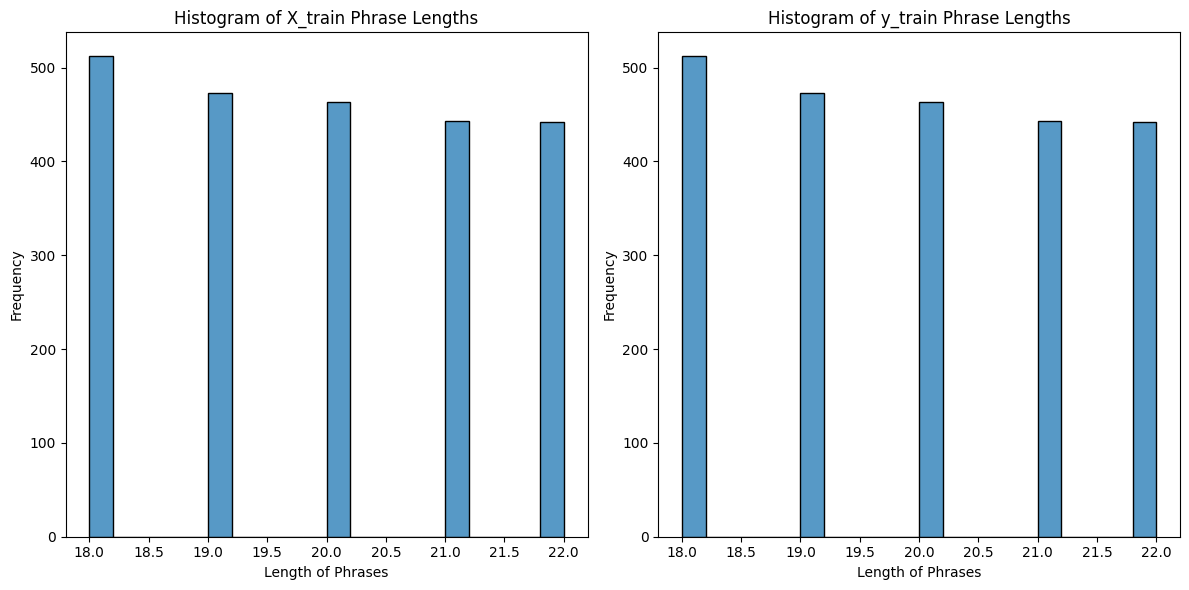

2333 Edward thinks he is in love with Bella . Rachel wants Edward to open his door . Rachel is outside .
vocabulary size 5839


In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
min_v = 18
max_v = 22
helper=Helper()
def load_x_y_train_plain():
    with open('corpus/train.json', 'r', encoding='utf-8') as f:
        try:
            dataset = json.load(f)  # Load the JSON data

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
    X_train = []
    y_train = []

    # #Loop through the list and process each dialogue and summary
    for data in dataset:
        dialogue = data['dialogue']  # Split dialogue into a list of lines
        summary = data['summary']

        X_train.append(dialogue)
        y_train.append(summary)
    return X_train, y_train


def split_x_y_train(X_train, y_train):
    X_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
    y_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]
    return X_train, y_train


# with open('data/vocabolary_full.pkl', 'rb') as f:
#     vocabulary=pickle.load(f)
def filter_train_data(X_train, y_train, to_eliminate):
    filtered_X_train = []
    filtered_y_train = []

    for x, y in zip(X_train, y_train):
        if not any(to_eliminate_str in x for to_eliminate_str in to_eliminate):
            filtered_X_train.append(x)
            filtered_y_train.append(y)

    return filtered_X_train, filtered_y_train


def create_complete_vocabulary(X_train, y_train):
    nlp_model = spacy.load('en_core_web_lg')
    nlp_model.disable_pipes(["parser", "ner"])
    complete_text_target = ' '.join(y_train)
    complete_text_origin = ' '.join(X_train)
    complete_text = complete_text_target + " [START] [PAD] [END] " + complete_text_origin

    vocabulary = helper.create_vocabulary(complete_text, "vocabolary_full", nlp_model)
    print("vocabulary size", len(vocabulary))
    return vocabulary


X_train, y_train = load_x_y_train_plain()
# to_eliminate = [
#     "[I hope I'm not coming off as rude - If I am, I'm sorry. I just thought it would be beneficial for the both of us...]",
#     "[pulls back the curtain and checks out the window]",
#     "[hopefully, masses of]"]
# X_train, y_train = filter_train_data(X_train, y_train, to_eliminate)


sample = [i for i in range(0,len(y_train))]


X_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
y_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]


X_train = [X_train[i] for i in sample if len(y_train[i]) <= max_v and len(y_train[i]) >= min_v]
y_train = [y_train[i] for i in sample if len(y_train[i]) <= max_v and len(y_train[i]) >= min_v]


# Calculate lengths of the tokenized phrases


def plot_lenghts(X_train,y_train):
    X_lengths = [len(x) for x in X_train]
    y_lengths = [len(y) for y in y_train]
    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Histogram for X_train lengths
    plt.subplot(1, 2, 1)
    sns.histplot(X_lengths, bins=20, kde=False)
    plt.title('Histogram of X_train Phrase Lengths')
    plt.xlabel('Length of Phrases')
    plt.ylabel('Frequency')

    # Histogram for y_train lengths
    plt.subplot(1, 2, 2)
    sns.histplot(y_lengths, bins=20, kde=False)
    plt.title('Histogram of y_train Phrase Lengths')
    plt.xlabel('Length of Phrases')
    plt.ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()

X_train=[i[::-1] for i in y_train]
plot_lenghts(X_train,y_train)
 

X_train=[" ".join(x) for x in X_train]
y_train=[" ".join(y) for y in y_train]

print(len(y_train),y_train[0])

vocabulary=create_complete_vocabulary(X_train, y_train)

In [3]:
class Encoder:
    def __init__(self,embedding_size,num_heads,linear_layer_size,learning_rate,batch_size,words_per_phrase,clipping_threshold):
        self.batch_size=batch_size
        self.clipping_threshold=clipping_threshold
        self.words_per_phrase=words_per_phrase
        self.num_heads=num_heads
        self.linear_layer_size=linear_layer_size
        self.embedding_size=embedding_size
        self.fully_connected_block=fully_connected_block(self.embedding_size,linear_layer_size,clipping_threshold=clipping_threshold)
        self.multihead_attention_encoder=multihead_attention(num_heads=2,embedding_size=embedding_size,batch_size=batch_size,threshold=clipping_threshold)
        self.residual_layer_1=residual_layer(clipping_threshold)
        self.residual_layer_2=residual_layer(clipping_threshold) 
        self.learning_rate=learning_rate
         
        self.helper=Helper()
     

    def forward(self,inputs_e):
        self.inputs_e=inputs_e 

        PrjAe=self.multihead_attention_encoder.forward_attention(inputs_e,inputs_e,inputs_e)
        
        Ect1=self.residual_layer_1.forward(PrjAe,inputs_e) 

        FLe2=self.fully_connected_block.forward(Ect1) 

        Ecout=self.residual_layer_2.forward(FLe2,Ect1)

        return Ecout
    
    def backpropagation(self,dL_Ecout): 
        
        dL_dFLe2,dL_dEct1_residual=self.residual_layer_2.grad(dL_Ecout)
        
        #print("dL_dFLe2",dL_dFLe2)
        #print("dL_dEct1_residual",dL_dFLe2)
        

        dL_dEct1=self.fully_connected_block.grad(dL_dFLe2)+dL_dEct1_residual
        #print("dL_dEct1",dL_dEct1)
        
        dL_dPrjAe,dL_inputs_e_residual=self.residual_layer_1.grad(dL_dEct1)
        #print("dL_dPrjAe",dL_dPrjAe)
        #print("dL_inputs_e_residual",dL_inputs_e_residual)
        dL_inputs_e_q,dL_inputs_e_k,dL_inputs_e_v=self.multihead_attention_encoder.grad(dL_dPrjAe)
        
        dL_inputs_e=dL_inputs_e_residual+dL_inputs_e_q+dL_inputs_e_k+dL_inputs_e_v

        #dL_inputs_e=clip_gradient(dL_inputs_e,self.clipping_threshold)
        #print("dL_inputs_e",dL_inputs_e_residual)
        dLoss_dWemb_encoder = dL_inputs_e * self.inputs_e
        return dL_inputs_e,dLoss_dWemb_encoder


    def update_weights(self,learning_rate,dLoss_dWemb_encoder,X_batch,vocabulary):
        self.residual_layer_2.update_weights(learning_rate)
        self.fully_connected_block.update_weights(learning_rate)
        self.residual_layer_1.update_weights(learning_rate)
        self.multihead_attention_encoder.update_weights(learning_rate)
        
        # input_e=self.inputs_e-learning_rate*dLoss_dWemb_encoder
        # vocabulary=self.helper.update_wembedding_encoder(X_batch,input_e,vocabulary,self.words_per_phrase)
        return vocabulary
        

  
      
     
class Decoder:
    def __init__(self,embedding_size,num_heads,linear_layer_size,learning_rate,batch_size,words_per_phrase,clipping_threshold):
        self.words_per_phrase=words_per_phrase
        self.clipping_threshold=clipping_threshold
        self.batch_size=batch_size
        self.num_heads=num_heads 
        self.linear_layer_size=linear_layer_size
        self.embedding_size=embedding_size  
        self.multihead_cross_attention=multihead_attention(num_heads=num_heads,embedding_size=embedding_size,batch_size=batch_size,threshold=clipping_threshold)
        self.multihead_attention_decoder=multihead_attention(num_heads=num_heads,embedding_size=embedding_size,batch_size=batch_size,threshold=clipping_threshold) 
        self.learning_rate=learning_rate
        self.helper=Helper() 
        self.residual_layer_1=residual_layer(threshold=clipping_threshold)
        self.residual_layer_2=residual_layer(threshold=clipping_threshold) 
        self.residual_layer_3=residual_layer(threshold=clipping_threshold) 
        self.fully_connected_block=fully_connected_block(self.embedding_size,linear_layer_size,clipping_threshold=clipping_threshold)
        

    def forward(self,inputs_decoder,Ecout):
        self.inputs_decoder=inputs_decoder 
        
        PrjA_mask=self.multihead_attention_decoder.forward_masked_attention(inputs_decoder,inputs_decoder,inputs_decoder,mask_size=inputs_decoder.shape[1])
 
        Dt1=self.residual_layer_1.forward(self.inputs_decoder,PrjA_mask)
 
        PrjAcr=self.multihead_cross_attention.forward_attention(Dt1,Ecout,Ecout)
   
        Dt2=self.residual_layer_2.forward(PrjAcr,Dt1)
 
        FLd2=self.fully_connected_block.forward(Dt2)
      
        Dout=self.residual_layer_3.forward(FLd2,Dt2)  

        return Dout
    
    # def output(self,Dout):
    #     SigmaZout=self.helper.softmax(self.final_projection_layer.forward(Dout))
    #     return SigmaZout


    def backpropagation(self,dL_dDout): 

        dL_FLd2,dL_Dt2_residual=self.residual_layer_3.grad(dL_dDout)

        dL_Dt2=self.fully_connected_block.grad(dL_FLd2)+dL_Dt2_residual

        dL_PrjAcr,dL_Dt1_residual=self.residual_layer_2.grad(dL_Dt2)

        dL_Dt1_q,dL_DEcout_k,dL_DEcout_v=self.multihead_cross_attention.grad(dL_PrjAcr)

        dL_Dt1=dL_Dt1_residual+dL_Dt1_q

        dL_PrjA_mask,dL_inputs_decoder_residual=self.residual_layer_1.grad(dL_Dt1)

        dL_inputs_decoder_q,dL_inputs_decoder_k,dL_inputs_decoder_v=self.multihead_attention_decoder.grad(dL_PrjA_mask)

        dL_inputs_decoder=dL_inputs_decoder_residual+dL_inputs_decoder_q+dL_inputs_decoder_k+dL_inputs_decoder_v
        
        dL_Ecout=dL_DEcout_k+dL_DEcout_v
        #dL_inputs_decoder=clip_gradient(dL_inputs_decoder,self.clipping_threshold)
        dLoss_dWemb_decoder= dL_inputs_decoder * self.inputs_decoder
        
        return dL_Ecout,dL_inputs_decoder,dLoss_dWemb_decoder


    def update_weights(self,learning_rate,dLoss_dWemb_decoder,y_batch,vocabulary):
        self.residual_layer_3.update_weights(learning_rate)
        self.fully_connected_block.update_weights(learning_rate)
        self.residual_layer_2.update_weights(learning_rate)
        self.multihead_cross_attention.update_weights(learning_rate)
        self.residual_layer_1.update_weights(learning_rate)
        self.multihead_attention_decoder.update_weights(learning_rate)
        #dLoss_dWemb_decoder=clip_gradient(dLoss_dWemb_decoder,self.clipping_threshold)
        # input_d=self.inputs_decoder-learning_rate*dLoss_dWemb_decoder
        # vocabulary=self.helper.update_wembedding_decoder(y_batch,input_d,self.words_per_phrase,vocabulary) 
        return vocabulary
        
    
class Transformer:
    def __init__(self,num_layers,embedding_size,num_heads,fl1_size,learning_rate,batch_size,words_per_phrase,clipping_threshold,vocabulary):
        self.vocabulary=vocabulary
        self.clipping_threshold=clipping_threshold
        self.EncoderStack = [Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,words_per_phrase,clipping_threshold) for _ in range(num_layers)]
        self.DecoderStack = [Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,words_per_phrase,clipping_threshold) for _ in range(num_layers)]


    def forward(self,inputs_e,inputs_decoder,X_batch,y_batch):

        self.X_batch=X_batch
        self.y_batch=y_batch
        Ecout=self.forward_encoder(inputs_e)
        Dout=self.forward_decoder(Ecout,inputs_decoder)
        return Dout
    
    def backpropagation(self,dL_dDout):
        dL_Ecout,dLoss_dWemb_decoder_tot=self.backpropagation_decoder(dL_dDout)
        dL_Ecout,dLoss_dWemb_encoder_tot=self.backpropagation_encoder(dL_Ecout)
        return dL_Ecout,dLoss_dWemb_encoder_tot,dLoss_dWemb_decoder_tot

    def forward_encoder(self,inputs_e):
        for encoder_i in self.EncoderStack:
            inputs_e=encoder_i.forward(inputs_e)
        return inputs_e
    
    def forward_decoder(self,Ecout,inputs_decoder):
        for decoder_i in self.DecoderStack:
            inputs_decoder=decoder_i.forward(inputs_decoder,Ecout)
        return inputs_decoder
    
    def backpropagation_decoder(self,dL_dDout):
        tot_dL_dEcout=0
        dLoss_dWemb_decoder_tot=0
        for decoder_i in reversed(self.DecoderStack):
            dL_Ecout_i,dL_dDout,dLoss_dWemb_decoder=decoder_i.backpropagation(dL_dDout)
            tot_dL_dEcout+=dL_Ecout_i
            dLoss_dWemb_decoder_tot+=dLoss_dWemb_decoder
            self.vocabulary=decoder_i.update_weights(decoder_i.learning_rate,dLoss_dWemb_decoder,self.y_batch,self.vocabulary)
        return tot_dL_dEcout,dLoss_dWemb_decoder_tot
    
    def backpropagation_encoder(self,dL_Ecout): 
        dLoss_dWemb_encoder_tot=0
        for encoder_i in reversed(self.EncoderStack):
            dL_Ecout,dLoss_dWemb_encoder=encoder_i.backpropagation(dL_Ecout) 
            dLoss_dWemb_encoder_tot+=dLoss_dWemb_encoder 
            self.vocabulary=encoder_i.update_weights(encoder_i.learning_rate,dLoss_dWemb_encoder,self.X_batch,self.vocabulary)
        return dL_Ecout,dLoss_dWemb_encoder_tot
   
 
    #     self.inputs_decoder=self.inputs_decoder-self.learning_rate*dLoss_dWemb_decoder
    #     vocabulary=self.helper.update_wembedding_decoder(y_batch,self.inputs_decoder,self.words_per_phrase,vocabulary) 
    #     return vocabulary



In [4]:
# import traceback
# embedding_size=300
# fl1_size=1000 
# batch_size=5
# num_heads=5
# dropout_rate=0.2
# words_per_phrase = num_phrases= max_v
# num_batches_per_epoch = len(X_train) // batch_size
# num_epochs=550
# tot_loss_epoch=0
# learning_rate=0.001

# Output_stack=output_stack(embedding_size,len(vocabulary))
# TransformerEncoder=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v)



# TransformerDecoder=Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v)
# TransformerEncoder1=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v)
# TransformerEncoder2=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v)

 


# for epoch in range(1):
#     print("Loss",tot_loss_epoch/num_batches_per_epoch)
#     tot_loss_epoch=0
#     total_accuracy_epoch=0
    
#     for i in tqdm(range(0,5),desc=f"Epoch {epoch + 1}/{num_epochs}"):
#         #try: 
#         start = i * batch_size
#         end = start + batch_size 
#         X_batch = X_train[start:end]
#         y_batch = y_train[start:end] 
        
        
#         #helper.print_matrix(y_batch)
#         #print("X_batch",X_batch)
        
        
#         inputs_e=helper.create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
#         inputs_decoder=helper.create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary) 
#         target_decoder=helper.create_target(y_batch,vocabulary,words_per_phrase)
#         #target_decoder=helper.generate_target_sparse_categorical(y_batch,vocabulary,words_per_phrase)
        
#         Ecout0 = TransformerEncoder.forward(inputs_e)
#         Ecout1=TransformerEncoder1.forward(Ecout0)
#         Ecout=TransformerEncoder2.forward(Ecout1)
#         Dout = TransformerDecoder.forward(inputs_decoder, Ecout)
        
        
#         SigmaZout = Output_stack.forward(Dout)

#         for j in range(SigmaZout.shape[0]):
#             for k in range(SigmaZout.shape[1]):
#                 #print(np.argmax(SigmaZout[j][k]),np.argmax(target_decoder[j][k]))
#                 pass
#         #print(target_decoder.shape)

#         #print("Loss",Output_stack.sparse_categorical_crossentropy(SigmaZout,target_decoder))
#         print("Loss",Output_stack.cross_entropy_loss(SigmaZout,target_decoder))
#         dL_dDout = Output_stack.grad_cross_entropy(SigmaZout,target_decoder)

#         print("dL_dDout",dL_dDout.shape) 
         
#         dL_Ecout,dLoss_dWemb_decoder = TransformerDecoder.backpropagation(dL_dDout)

#         dLoss_dWemb_encoder0=TransformerEncoder.backpropagation(dL_Ecout) 
#         dLoss_dWemb_encoder1=TransformerEncoder1.backpropagation(dLoss_dWemb_encoder0) 
#         dLoss_dWemb_encoder2=TransformerEncoder2.backpropagation(dLoss_dWemb_encoder1) 

        
#         TransformerDecoder.update_weights(learning_rate)
#         TransformerDecoder.update_weights(learning_rate)
#         Output_stack.update_weights(learning_rate)
        #inputs_decoder=inputs_decoder-learning_rate*dLoss_dWemb_decoder
        #vocabulary=helper.update_wembedding_decoder(y_batch,inputs_decoder,words_per_phrase,vocabulary) 
        #inputs_e=inputs_e-learning_rate*dLoss_dWemb_encoder
        #vocabulary=helper.update_wembedding_encoder(X_batch,inputs_e,vocabulary,words_per_phrase)
        #print("dL_Ecout",dL_Ecout.shape)


In [5]:
# import traceback
# embedding_size=300
# fl1_size=2048
# batch_size=8
# num_heads=10
# dropout_rate=0.1
# words_per_phrase = num_phrases= max_v
# num_batches_per_epoch = len(X_train) // batch_size
# num_epochs=550
# tot_loss_epoch=0
# learning_rate=0.0001

# Output_stack=output_stack(embedding_size,len(vocabulary),threshold=1)
# TransformerEncoder=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v,clipping_threshold=1)
# TransformerDecoder=Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v,clipping_threshold=1)

 


# for epoch in range(1):
#     print("Loss",tot_loss_epoch/num_batches_per_epoch)
#     tot_loss_epoch=0
#     total_accuracy_epoch=0
    
#     for i in tqdm(range(0,6),desc=f"Epoch {epoch + 1}/{num_epochs}"):
#         #try: 
#         start = i * batch_size
#         end = start + batch_size 
#         X_batch = X_train[start:end]
#         y_batch = y_train[start:end] 
        
        
#         #helper.print_matrix(y_batch)
#         #print("X_batch",X_batch)
        
        
#         inputs_e=helper.create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
#         inputs_decoder=helper.create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary) 
#         #target_decoder=helper.create_target(y_batch,vocabulary,words_per_phrase)
#         target_decoder=helper.generate_target_sparse_categorical(y_batch,vocabulary,words_per_phrase)
        
#         Ecout = TransformerEncoder.forward(inputs_e)
         
#         Dout = TransformerDecoder.forward(inputs_decoder, Ecout)
        
#         SigmaZout = Output_stack.forward(Dout)
        
#         print("SigmaZout.shape",SigmaZout.shape)
#         print("target_decoder.shape",target_decoder.shape)
#         print("Loss",Output_stack.sparse_categorical_crossentropy(SigmaZout,target_decoder))
#         dL_dDout = Output_stack.grad_sparse_cross_entropy(SigmaZout,target_decoder)
#         #print("Loss",Output_stack.Loss_cross_entropy(SigmaZout,target_decoder))
#         #dL_dDout = Output_stack.grad_cross_entropy(SigmaZout,target_decoder)

#         print("dL_dDout",dL_dDout.shape) 
         
#         dL_Ecout,dLoss_dWemb_decoder = TransformerDecoder.backpropagation(dL_dDout)

#         dLoss_dWemb_encoder=TransformerEncoder.backpropagation(dL_Ecout) 
        
        

        
#         TransformerDecoder.update_weights(learning_rate)
#         TransformerDecoder.update_weights(learning_rate)
#         Output_stack.update_weights(learning_rate)
#         #inputs_decoder=inputs_decoder-learning_rate*dLoss_dWemb_decoder
#         #vocabulary=helper.update_wembedding_decoder(y_batch,inputs_decoder,words_per_phrase,vocabulary) 
#         #inputs_e=inputs_e-learning_rate*dLoss_dWemb_encoder
#         #vocabulary=helper.update_wembedding_encoder(X_batch,inputs_e,vocabulary,words_per_phrase)
#         #print("dL_Ecout",dL_Ecout.shape)


In [6]:
len(X_train),len(vocabulary)

(2333, 5839)

In [7]:
import traceback
embedding_size=300
fl1_size=2048
batch_size=64
num_heads=15
dropout_rate=0.1
words_per_phrase = num_phrases= max_v
num_batches_per_epoch = len(X_train) // batch_size
num_epochs=550
tot_loss_epoch=0
learning_rate=0.000005
clipping_threshold=9000000000



n_layers=7
Output_stack=output_stack(embedding_size,len(vocabulary),threshold=clipping_threshold)
MyTransformer=Transformer(n_layers,embedding_size,num_heads,fl1_size,learning_rate,batch_size,words_per_phrase,clipping_threshold,vocabulary)
output_linear_layer=linear_layer(embedding_size,len(vocabulary),out=True) 
accuracies=[0,0]
mean_acc=0

In [13]:
 
 
 
for epoch in range(550):
    print("Loss",tot_loss_epoch/num_batches_per_epoch,"mean accuracy",np.mean(np.array(accuracies)))#np.mean(np.array(accuracies))
    tot_loss_epoch=0
    total_accuracy_epoch=0
    mean_acc=0
    accuracies=[]
    for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
        #try: 
        start = i * batch_size
        end = start + batch_size 
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]  
        
        inputs_e=helper.create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
        inputs_decoder=helper.create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary) 
        target_decoder=helper.create_target(y_batch,vocabulary,words_per_phrase) 
        Dout=MyTransformer.forward(inputs_e,inputs_decoder,X_batch,y_batch)
        counter_beccate=0
        counter_tot=0 
        SigmaZout = Output_stack.forward(Dout)
        
        taccuracies=[]
        for n in range(SigmaZout.shape[0]): 
            len_phrase=SigmaZout.shape[1]
            counter_beccate=0 
            for l in range(SigmaZout.shape[1]): 
                if np.argmax(SigmaZout[n][l])==np.argmax(target_decoder[n][l]): 
                    counter_beccate+=1
                    #print(np.argmax(SigmaZout[n][l]))
            phrase_accuracy=counter_beccate/len_phrase
            taccuracies.append(phrase_accuracy)

        accuracies.append(np.mean(np.array(taccuracies))) 


        Loss = Output_stack.cross_entropy_loss(SigmaZout,target_decoder) 
        tot_loss_epoch+=Loss
 
        dL_dDout = Output_stack.grad_cross_entropy(SigmaZout,target_decoder)
        
         


        dL_Ecout,dLoss_dWemb_encoder_tot,dLoss_dWemb_decoder_tot=MyTransformer.backpropagation(dL_dDout) 
        Output_stack.update_weights(learning_rate)
        vocabulary=helper.update_wembedding_decoder(learning_rate,y_batch, dLoss_dWemb_decoder_tot,vocabulary, max_v  )
        vocabulary=helper.update_wembedding_encoder(learning_rate,X_batch, dLoss_dWemb_encoder_tot,vocabulary,max_v)



Loss 0.0006913768694590593 mean accuracy 0.08025568181818182


Epoch 1/550: 100%|██████████| 36/36 [02:07<00:00,  3.54s/it]


Loss 0.025111417499660293 mean accuracy 0.08057133838383838


Epoch 2/550: 100%|██████████| 36/36 [02:06<00:00,  3.50s/it]


Loss 0.024913476405349536 mean accuracy 0.08031486742424243


Epoch 3/550: 100%|██████████| 36/36 [02:04<00:00,  3.46s/it]


Loss 0.024751447091849274 mean accuracy 0.08039378156565657


Epoch 4/550: 100%|██████████| 36/36 [02:05<00:00,  3.49s/it]


Loss nan mean accuracy 0.043185763888888895


Epoch 5/550:   8%|▊         | 3/36 [00:12<02:12,  4.01s/it]


KeyboardInterrupt: 

In [12]:
for i,(j,k) in vocabulary.items():
    print(i,k)
    if k==2347:
        print(i)

seeing 0
schools 1
released 2
disappeared 3
shat 4
bath 5
Octavia 6
pole 7
garage 8
seeded 9
should 10
gathered 11
promote 12
Paulson 13
hate 14
o 15
Groundhog 16
Nat 17
Jesus 18
tips 19
story 20
cost 21
gala 22
Leona 23
goalkeeper 24
Monopoly 25
Jimena 26
road 27
chase 28
season 29
Beyonce 30
Samoa 31
Josiah 32
Gladys 33
Aztec 34
travels 35
Bay 36
favour 37
hurry 38
radio 39
heart 40
learn 41
Cecil 42
Carter 43
last 44
Tatiana 45
expressed 46
such 47
Mars 48
A 49
Eminem 50
6 51
overweight 52
loaf 53
tenant 54
Leon 55
looking 56
hair 57
butter 58
go 59
pears 60
Austin 61
Stacy 62
carom 63
training 64
notes 65
Audley 66
PlayStation 67
Sue 68
bonus 69
Susy 70
Lesser 71
desperate 72
with 73
common 74
quits 75
drowned 76
grammar 77
sporting 78
shout 79
fuse 80
suggest 81
fingers 82
could 83
liquid 84
Alexi 85
best 86
Amore 87
Daddy 88
Barca 89
music 90
Hamza 91
messaged 92
Wade 93
box 94
riding 95
Damari 96
worry 97
funeral 98
Wacky 99
consequences 100
Formula 101
omelette 102
Hartley 103


In [ ]:
 
# learning_rate=0.00001
 
# for epoch in range(550):
#     print("Loss",tot_loss_epoch/num_batches_per_epoch,"mean accuracy",np.mean(np.array(accuracies)))#np.mean(np.array(accuracies))
#     tot_loss_epoch=0
#     total_accuracy_epoch=0
#     mean_acc=0
#     accuracies=[]
#     for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
#         #try: 
#         start = i * batch_size
#         end = start + batch_size 
#         X_batch = X_train[start:end]
#         y_batch = y_train[start:end] 
        
        
#         #helper.print_matrix(y_batch)
#         #print("X_batch",X_batch)
        
        
#         inputs_e=helper.create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
#         inputs_decoder=helper.create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary) 
#         target_decoder=helper.create_target(y_batch,vocabulary,words_per_phrase)
#         #target_decoder=helper.generate_target_sparse_categorical(y_batch,vocabulary,words_per_phrase)
#         #print("target_decoder",target_decoder.shape)
#         #print("inputs_decoder",inputs_decoder.shape)
#         #target_decoder=inputs_decoder

#         Dout=MyTransformer.forward(inputs_e,inputs_decoder,X_batch,y_batch)
#         counter_beccate=0
#         counter_tot=0
#         #Zout = output_linear_layer.forward(Dout)
#         #SigmaZout = helper.softmax(Zout)
#         SigmaZout = Output_stack.forward(Dout)
        
#         taccuracies=[]
#         for n in range(SigmaZout.shape[0]): 
#             len_phrase=SigmaZout.shape[1]
#             counter_beccate=0 
#             for l in range(SigmaZout.shape[1]): 
#                 if np.argmax(SigmaZout[n][l])==np.argmax(target_decoder[n][l]): 
#                     counter_beccate+=1
#                     #print(np.argmax(SigmaZout[n][l]))
#             phrase_accuracy=counter_beccate/len_phrase
#             taccuracies.append(phrase_accuracy)

#         accuracies.append(np.mean(np.array(taccuracies)))
#         # if np.mean(np.array(accuracies))>0:
#         #         print(np.mean(np.array(accuracies)))
#                 #print(np.argmax(SigmaZout[n][l]),np.argmax(target_decoder[n][l]))
#         #print(target_decoder)

#         # for n in range(SigmaZout.shape[0]):
#         #     phrase_len=SigmaZout.shape[1]
#         #     phrase_accuracy=0
#         #     counter_beccate=0
#         #     for l in range(SigmaZout.shape[1]):
#         #         if np.argmax(SigmaZout[n][l])==target_decoder[n][l]:
#         #             counter_beccate+=1
#         #             #print(target_decoder[n][l],np.argmax(SigmaZout[n][l]))
#         #     phrase_accuracy=counter_beccate/phrase_len
#         #     if(phrase_accuracy>0):
#         #         pass
#                 #print("phrase_accuracy",phrase_accuracy)
                
#         #  #print("Dout",Dout.shape)
#         #print("SigmaZout",SigmaZout.shape)
#         #mean_acc+=(phrase_accuracy/counter_tot)
#         #Loss=Output_stack.cross_entropy_loss(SigmaZout,target_decoder)
#         #Loss=Output_stack.sparse_categorical_crossentropy(SigmaZout,target_decoder)
#         #print("Loss",Loss)



#         Loss = Output_stack.cross_entropy_loss(SigmaZout,target_decoder)
#         #dLoss_dZout = SigmaZout - target_decoder 
        
#         #dLoss_dDout= output_linear_layer.grad(dLoss_dZout)
#         #dL_dDout = dLoss_dZout @ output_linear_layer.W.T
#         tot_loss_epoch+=Loss



#         #dL_dDout = Output_stack.grad_sparse_cross_entropy(SigmaZout,target_decoder)
#         dL_dDout = Output_stack.grad_cross_entropy(SigmaZout,target_decoder)
        
         


#         dL_Ecout,dLoss_dWemb_encoder_tot,dLoss_dWemb_decoder_tot=MyTransformer.backpropagation(dL_dDout)
#         #inputs_decoder=inputs_decoder-learning_rate*dLoss_dWemb_decoder
#         #vocabulary=helper.update_wembedding_decoder(y_batch,inputs_decoder,words_per_phrase,vocabulary) 
#         #inputs_e=inputs_e-learning_rate*dLoss_dWemb_encoder
#         #vocabulary=helper.update_wembedding_encoder(X_batch,inputs_e,vocabulary,words_per_phrase)
#         #print("dL_Ecout",dL_Ecout.shape)
#         Output_stack.update_weights(learning_rate)
#         vocabulary=helper.update_wembedding_decoder(learning_rate,y_batch, dLoss_dWemb_decoder_tot,vocabulary, max_v  )
#         vocabulary=helper.update_wembedding_encoder(learning_rate,X_batch, dLoss_dWemb_encoder_tot,vocabulary,max_v)



In [ ]:
import traceback
# inputs_e=cp.random.rand(4,11,300)
# inputs_d=cp.random.rand(11,4,11,300)
# target_i=cp.array([1, 2,3,4])
# TransformerEncoder=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v)
# TransformerDecoder=Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v,vocabulary_size=len(vocabulary))
# words_per_phrase = num_phrases= max_v
# output_linear_layer=linear_layer(embedding_size,len(vocabulary),out=True)  
# num_batches_per_epoch = len(X_train) // batch_size
# num_epochs=550
# tot_loss_epoch=0

# for epoch in range(num_epochs):
#     print("Loss",tot_loss_epoch/num_batches_per_epoch)
#     tot_loss_epoch=0
#     total_accuracy_epoch=0
    
#     for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
#         #try: 
#         start = i * batch_size
#         end = start + batch_size 
#         X_batch = X_train[start:end]
#         y_batch = y_train[start:end] 
#         #print("y_batch",y_batch)
#         #print(X_batch)
#         inputs_e=helper.create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
#         inputs_decoder=helper.create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary) 
#         Ecout=TransformerEncoder.forward(inputs_e)
        
        
#         #print("inputs_d.shape",inputs_d.shape,"inputs_e.shape",inputs_e.shape) 
#         target_d=helper.create_target(y_batch,vocabulary,words_per_phrase,embedding_size)
       

#         Dout = TransformerDecoder.forward(inputs_decoder, Ecout)
        # target_d=helper.pad_sequences(y_batch,lenght=words_per_phrase,target_type="target") 
        # target_d=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in target_d] 
        # tot_loss=0
        # totdLoss_dAcr=0
        # counter_correct=0
        # total_accuracy_batch=0
        # for step in range(0, inputs_d.shape[0]):
        #     inputs_decoder = inputs_d[step]
        #     target_i = cp.array([helper.get_one_hot(x[step], vocabulary) for x in target_d])
        #     #target_i=cp.array([vocabulary[x[step]][1] for x in target_d])
        #     Dout = TransformerDecoder.forward(inputs_decoder, Ecout)
        #     Zout = output_linear_layer.forward(Dout)
        #     SigmaZout = helper.softmax(Zout)
        #     print(SigmaZout.shape)
        #     # Calculate loss
        #     Loss = helper.cross_entropy_loss(SigmaZout, target_i)
        #     dLoss_dZout = SigmaZout - target_i 
        #     # Loss = helper.sparse_categorical_crossentropy(SigmaZout, target_i)  
        #     # dLoss_dZout = SigmaZout.copy()  # Create a copy of the softmax output 
        #     # dLoss_dZout[np.arange(target_i.shape[0]), target_i] -= 1 

        #     #helper.log_sparse_entropy(SigmaZout, target_i,y_batch,step)
        #     print("Loss",Loss)
        #     print("dLoss_dZout",dLoss_dZout.shape)
            # Backpropagation
            
            # clip_value = 1.0
            # dLoss_dZout = cp.clip(dLoss_dZout, -clip_value, clip_value)
            #dLoss_dDout= output_linear_layer.grad(dLoss_dZout)
            #dLoss_dDout = dLoss_dZout @ output_linear_layer.W.T
            
            # Backpropagation through decoder
            # vocabulary, dLoss_dAcr = TransformerDecoder.backpropagation(dLoss_dDout, vocabulary, y_batch)
            # tot_loss+=Loss 
            # batch_acc=helper.accruacy_sparse_entropy(SigmaZout,target_i)
            # total_accuracy_batch+=batch_acc
            # if batch_acc>0:
            #     helper.print_target_vs_prediction_sparce_loss(SigmaZout,target_i)
        #print("total_accuracy_batch",total_accuracy_batch)
        
        # dLoss_dAcr = cp.clip(dLoss_dAcr, -clip_value, clip_value)
        # dLoss_Ecout=cp.clip(dLoss_dAcr, -clip_value, clip_value)
        # After decoder, calculate gradients for encoder
        # dLoss_Ecout_k = TransformerDecoder.multihead_cross_attention.diffKInput(dLoss_dAcr, TransformerDecoder.Kc.W)
        # dLoss_Ecout_v = TransformerDecoder.multihead_cross_attention.diffVInput(dLoss_dAcr, TransformerDecoder.Vc.W)
        # dLoss_Ecout = dLoss_Ecout_k + dLoss_Ecout_v
        
        #     # Backpropagation through encoder
        # vocabulary = TransformerEncoder.backpropagation(dLoss_Ecout, vocabulary, X_batch)
        
        # tot_loss_epoch+=tot_loss/inputs_d.shape[0] 
        # total_accuracy_epoch+=total_accuracy_batch
 
        # except Exception as e:
        #     print(e)
        #     traceback.print_exc()  
    # print("total_accuracy_epoch",total_accuracy_epoch)